# Speech Emotion Recognition Project

<!-- ## Contributors to this project:

<b>
<li>Umesh Chandra Sakinala - 21BCE1782
<li>Sujan Kumar Sollety - 21BCE5667
<li>Harshith Simha Gurram - 21BCE5653
<li>Pulipaka Phani Meghana - 21BCE1345
<li>Pandithradhyula Soumya - 21BCE1424
</b> -->

In [1]:
!mkdir ~/.kaggle

In [2]:
!touch ~/.kaggle/kaggle.json

In [3]:
api_token = {"username":"umesh109","key":"aef50af22b6fe262935d024c7c135ac8"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=d3e095aec5af5cc05f9e4584722b42fa2adc5ac5d1dabb8cd6c440f08c53ff77
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [6]:
import pandas as pd
import numpy as np

import kaggle

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Downloading Datasets

In [7]:
!kaggle datasets download -d ejlok1/cremad

 98% 443M/451M [00:05<00:00, 81.2MB/s]
100% 451M/451M [00:05<00:00, 82.5MB/s]


In [8]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 97% 415M/429M [00:03<00:00, 161MB/s]
100% 429M/429M [00:03<00:00, 131MB/s]
 89% 96.0M/107M [00:01<00:00, 131MB/s]
100% 107M/107M [00:01<00:00, 98.4MB/s]
 98% 419M/428M [00:06<00:00, 56.6MB/s]
100% 428M/428M [00:06<00:00, 65.1MB/s]


### Unzip the datasets

In [9]:
!unzip /content/cremad.zip
!unzip /content/ravdess-emotional-speech-audio.zip
!unzip /content/surrey-audiovisual-expressed-emotion-savee.zip

Streaming output truncated to the last 5000 lines.
  inflating: AudioWAV/1072_DFA_DIS_XX.wav  
  inflating: AudioWAV/1072_DFA_FEA_XX.wav  
  inflating: AudioWAV/1072_DFA_HAP_XX.wav  
  inflating: AudioWAV/1072_DFA_NEU_XX.wav  
  inflating: AudioWAV/1072_DFA_SAD_XX.wav  
  inflating: AudioWAV/1072_IEO_ANG_HI.wav  
  inflating: AudioWAV/1072_IEO_ANG_LO.wav  
  inflating: AudioWAV/1072_IEO_ANG_MD.wav  
  inflating: AudioWAV/1072_IEO_DIS_HI.wav  
  inflating: AudioWAV/1072_IEO_DIS_LO.wav  
  inflating: AudioWAV/1072_IEO_DIS_MD.wav  
  inflating: AudioWAV/1072_IEO_FEA_HI.wav  
  inflating: AudioWAV/1072_IEO_FEA_LO.wav  
  inflating: AudioWAV/1072_IEO_FEA_MD.wav  
  inflating: AudioWAV/1072_IEO_HAP_HI.wav  
  inflating: AudioWAV/1072_IEO_HAP_LO.wav  
  inflating: AudioWAV/1072_IEO_HAP_MD.wav  
  inflating: AudioWAV/1072_IEO_NEU_XX.wav  
  inflating: AudioWAV/1072_IEO_SAD_HI.wav  
  inflating: AudioWAV/1072_IEO_SAD_LO.wav  
  inflating: AudioWAV/1072_IEO_SAD_MD.wav  
  inflating: AudioWAV/107

In [10]:
!unzip /content/toronto-emotional-speech-set-tess.zip

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

### Paths for Datasets

In [11]:
Ravdess = r"/content/audio_speech_actors_01-24"
Crema = r"/content/AudioWAV"
Tess = r"/content/TESS Toronto emotional speech set data"
Savee = r"/content/ALL"

## 1. Ravdess DataFrame

In [12]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess +'/'+ dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    happy  /content/audio_speech_actors_01-24/Actor_13/03...
1     calm  /content/audio_speech_actors_01-24/Actor_13/03...
2      sad  /content/audio_speech_actors_01-24/Actor_13/03...
3  disgust  /content/audio_speech_actors_01-24/Actor_13/03...
4  neutral  /content/audio_speech_actors_01-24/Actor_13/03...

## 2. Crema DataFrame

In [13]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '\\' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                   Path
0    happy  /content/AudioWAV\1057_DFA_HAP_XX.wav
1    happy  /content/AudioWAV\1046_TSI_HAP_XX.wav
2    angry  /content/AudioWAV\1026_TIE_ANG_XX.wav
3  neutral  /content/AudioWAV\1061_IOM_NEU_XX.wav
4  neutral  /content/AudioWAV\1010_IEO_NEU_XX.wav

##3. TESS dataset

In [14]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess +'/'+ dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0      sad  /content/TESS Toronto emotional speech set dat...
1      sad  /content/TESS Toronto emotional speech set dat...
2      sad  /content/TESS Toronto emotional speech set dat...
3      sad  /content/TESS Toronto emotional speech set dat...
4      sad  /content/TESS Toronto emotional speech set dat...

##4. CREMA-D dataset

The audio files in this dataset are named in a way such that the prefix letters describes the emotion classes as the below:

<ul>
<li> 'a' = Anger
<li> 'd' = Disgust
<li> 'f' = Fear
<li> 'h' = Happiness
<li> 'n' = Neutral
<li> 'sa' = Sadness
<li> 'su' = Surprise
</ul>

In [15]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + '\\' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                     Path
0  neutral  /content/ALL\KL_n30.wav
1  disgust  /content/ALL\KL_d03.wav
2    happy  /content/ALL\JK_h14.wav
3    angry  /content/ALL\DC_a03.wav
4     fear  /content/ALL\JE_f10.wav

In [16]:
#creating combined dataframe
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

Emotions                                               Path
0       happy  /content/audio_speech_actors_01-24/Actor_13/03...
1        calm  /content/audio_speech_actors_01-24/Actor_13/03...
2         sad  /content/audio_speech_actors_01-24/Actor_13/03...
3     disgust  /content/audio_speech_actors_01-24/Actor_13/03...
4     neutral  /content/audio_speech_actors_01-24/Actor_13/03...
...       ...                                                ...
1435     calm  /content/audio_speech_actors_01-24/Actor_02/03...
1436    angry  /content/audio_speech_actors_01-24/Actor_02/03...
1437  neutral  /content/audio_speech_actors_01-24/Actor_02/03...
1438     calm  /content/audio_speech_actors_01-24/Actor_02/03...
1439  disgust  /content/audio_speech_actors_01-24/Actor_02/03...

[1440 rows x 2 columns]

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

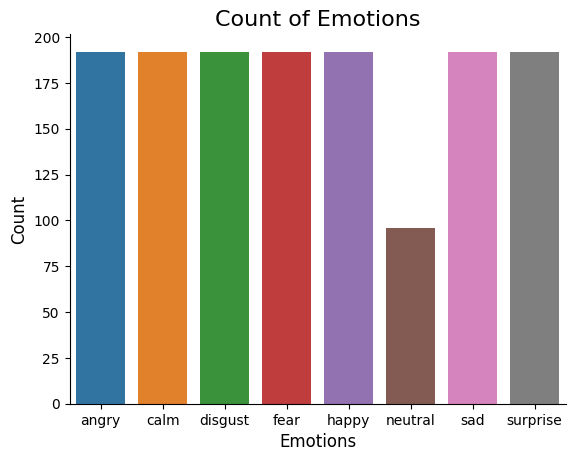

In [18]:
data_path['Emotions'] = data_path['Emotions'].astype('category')

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')  # Specify x parameter
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals
<li> Waveplots - Waveplots let us know the loudness of the audio at a given time
<li> Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to time for given audio/music signals.

In [19]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# Wave Plots for the Emotions

## <li>Fear

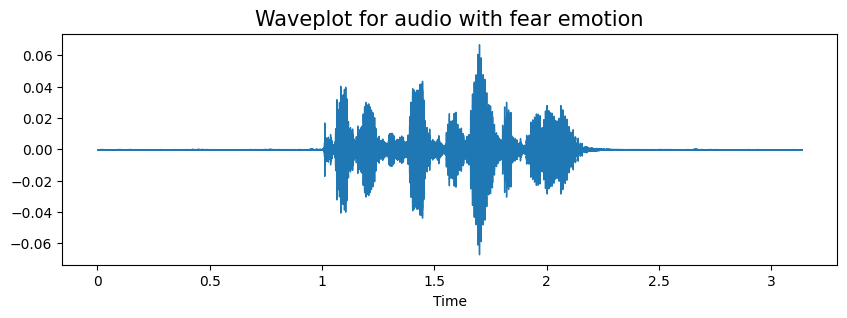

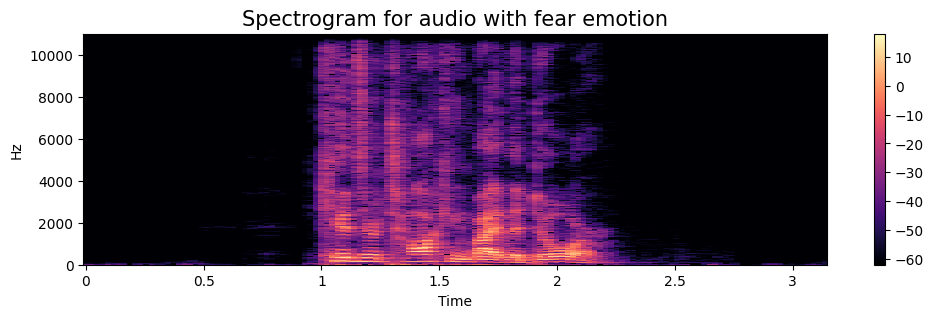

In [20]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Angry

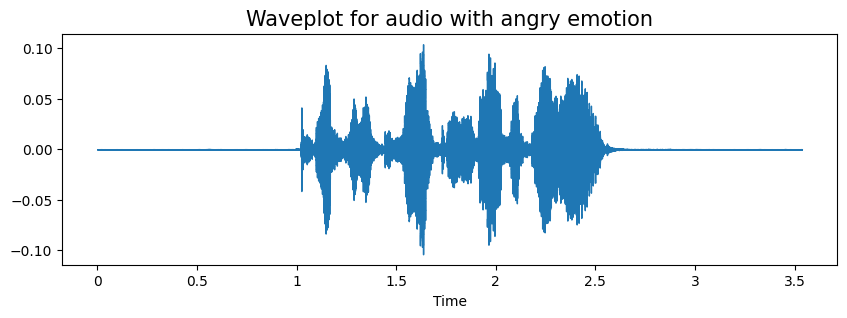

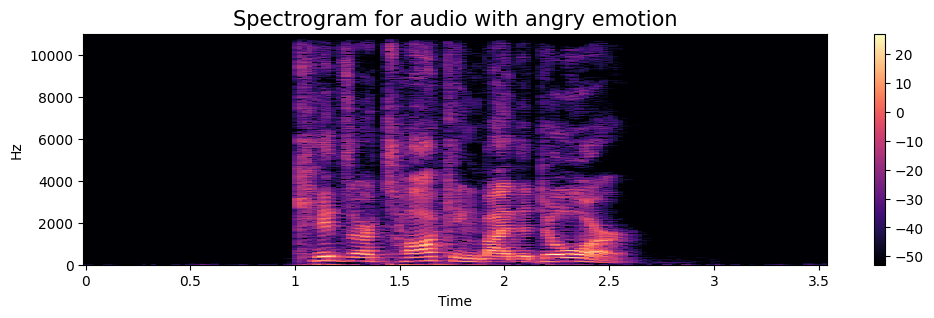

In [21]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Sad

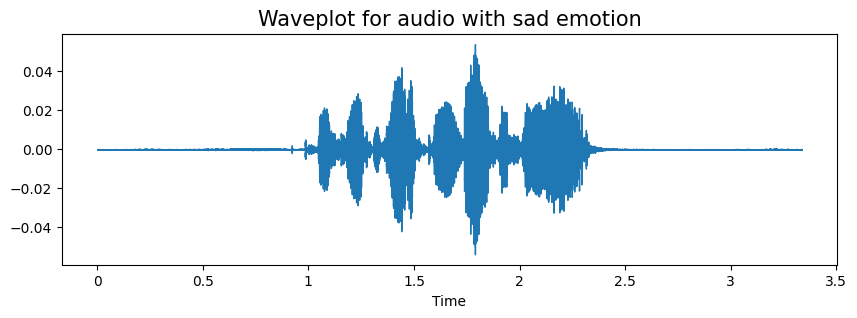

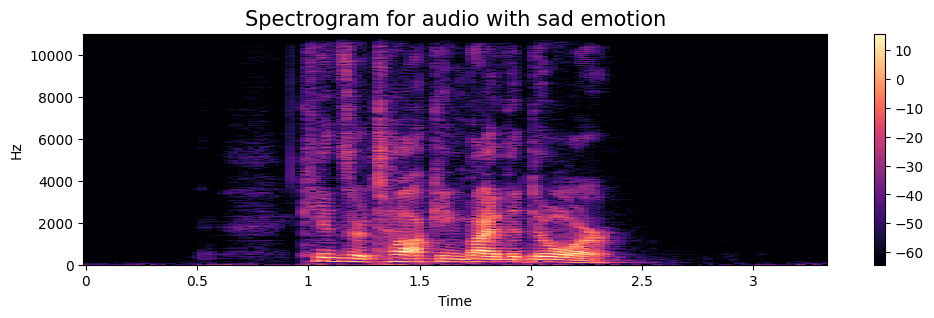

In [22]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Happy

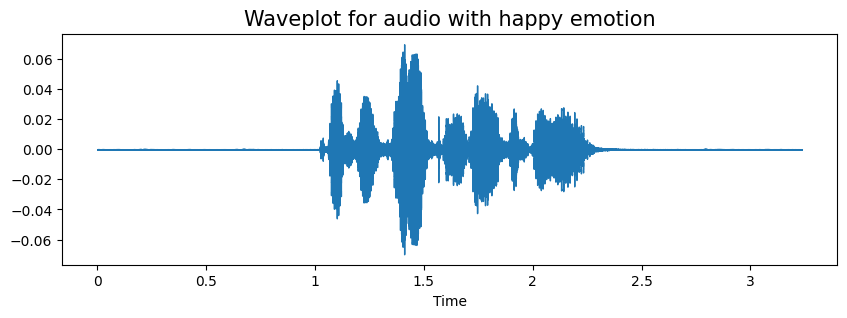

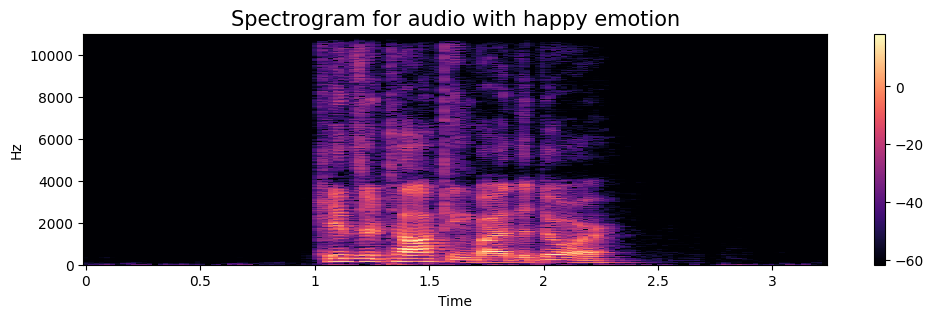

In [23]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

<li>To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed
<li>The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
<li>In order to this to work adding the perturbations must conserve the same label as the original training sample.
<li>In images data augmention can be performed by shifting the image, zooming, rotating, cropping ...etc

But We need to check which augmentation techinques works better for our dataset

In [45]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

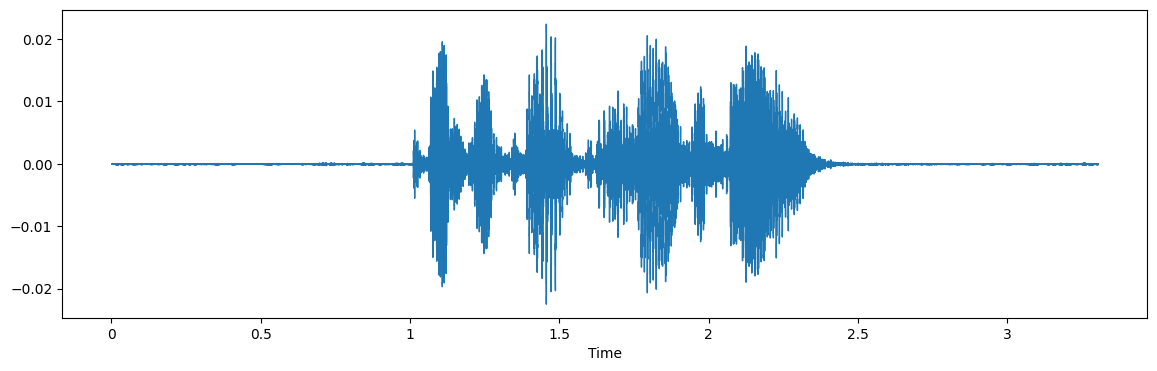

In [25]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

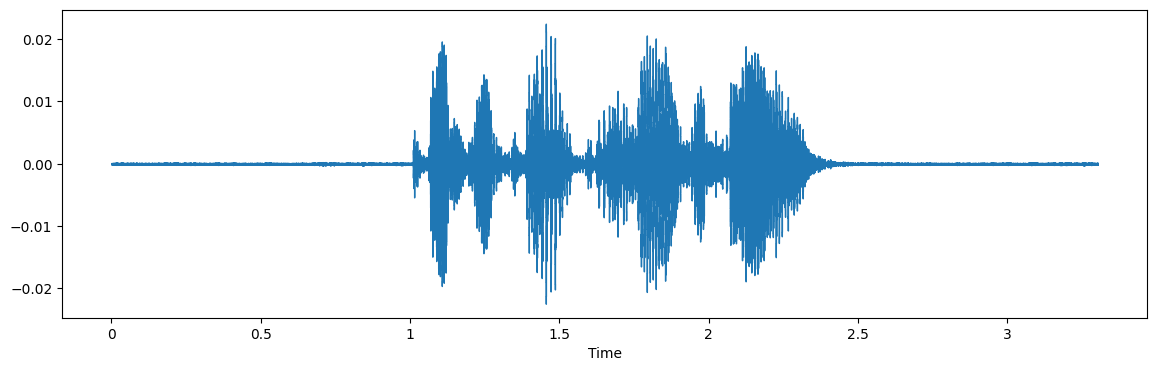

In [26]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Here, we can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3.Stretching

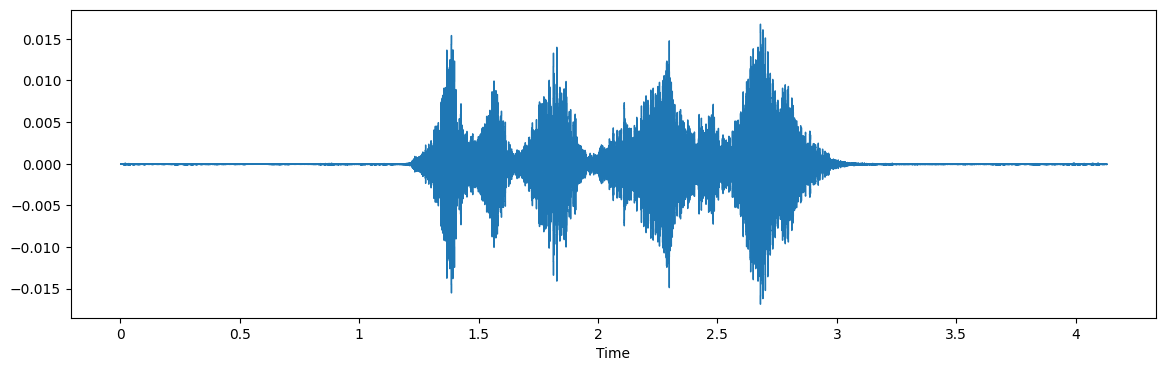

In [39]:
x = stretch(data, rate=0.8)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4.Shifting

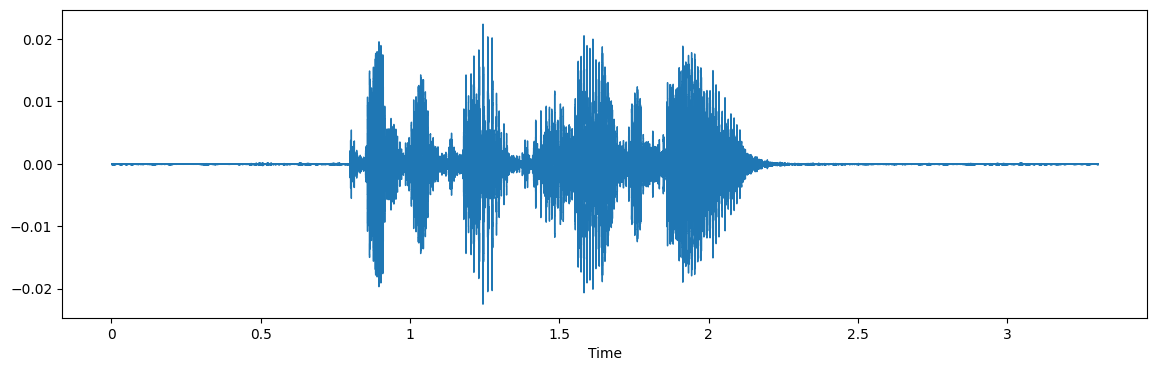

In [40]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.Pitch

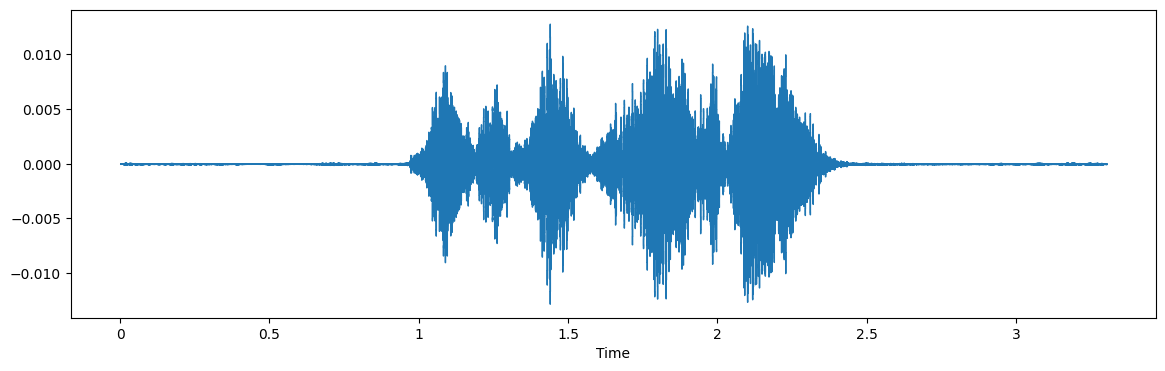

In [46]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

I am employing noise injection, stretching (i.e., changing speed), and pitch modulation as part of the aforementioned augmentation techniques.

## Feature Extraction

In [47]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [48]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [49]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [50]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.170026  0.570903  0.597957  0.653943  0.688549  0.626548  0.670124   
1  0.305135  0.757943  0.739535  0.776800  0.823039  0.787579  0.720865   
2  0.118902  0.639228  0.569077  0.532737  0.587575  0.644850  0.599069   
3  0.208885  0.719110  0.723938  0.756758  0.728095  0.653231  0.619650   
4  0.302635  0.761169  0.793346  0.831787  0.808383  0.756572  0.711092   

          7         8         9  ...           153           154  \
0  0.719093  0.668005  0.677699  ...  3.986506e-05  6.038000e-05   
1  0.719917  0.741830  0.682585  ...  4.873969e-04  5.625811e-04   
2  0.635975  0.664279  0.654691  ...  1.214907e-05  1.018256e-05   
3  0.627261  0.719079  0.715079  ...  4.470128e-07  9.548808e-07   
4  0.653989  0.728099  0.729594  ...  2.248048e-05  2.413074e-05   

            155           156           157       158       159           160  \
0  9.381986e-05  1.536290e-04  2.662582e-04  0.000219  0.000186  6.577724e-05   
1  5.558494e-04  6.173164e-04  7.200634e-04  0.000680  0.000650  5.377196e-04   
2  1.329098e-05  1.854815e-05  2.008742e-05  0.000036  0.000054  2.226951e-05   
3  3.853596e-07  3.843310e-07  9.467997e-07  0.000001  0.000002  8.938700e-07   
4  2.228004e-05  2.343087e-05  2.274550e-05  0.000024  0.000026  2.367071e-05   

            161  labels  
0  5.814185e-06   happy  
1  4.664542e-04   happy  
2  1.575359e-06   happy  
3  4.232520e-08    calm  
4  2.297734e-05    calm  

[5 rows x 163 columns]

We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [51]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [52]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [53]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [54]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [55]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Modelling

In [56]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [57]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 26s 470ms/step - loss: 2.0060 - accuracy: 0.1957 - val_loss: 1.9356 - val_accuracy: 0.2324 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 22s 440ms/step - loss: 1.9339 - accuracy: 0.2346 - val_loss: 1.8575 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 22s 426ms/step - loss: 1.8876 - accuracy: 0.2574 - val_loss: 1.8108 - val_accuracy: 0.3213 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 22s 438ms/step - loss: 1.8367 - accuracy: 0.2744 - val_loss: 1.8117 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 22s 429ms/step - loss: 1.7905 - accuracy: 0.3040 - val_loss: 1.6844 - val_accuracy: 0.3685 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 21s 414ms/step - loss: 1.7238 - accuracy: 0.3346 - val_loss: 1.6180 - val_accuracy: 0.3991 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 23s 447ms/st

34/34 [==============================] - 2s 44ms/step - loss: 1.3231 - accuracy: 0.6380
Accuracy of our model on test data :  63.79629373550415 %


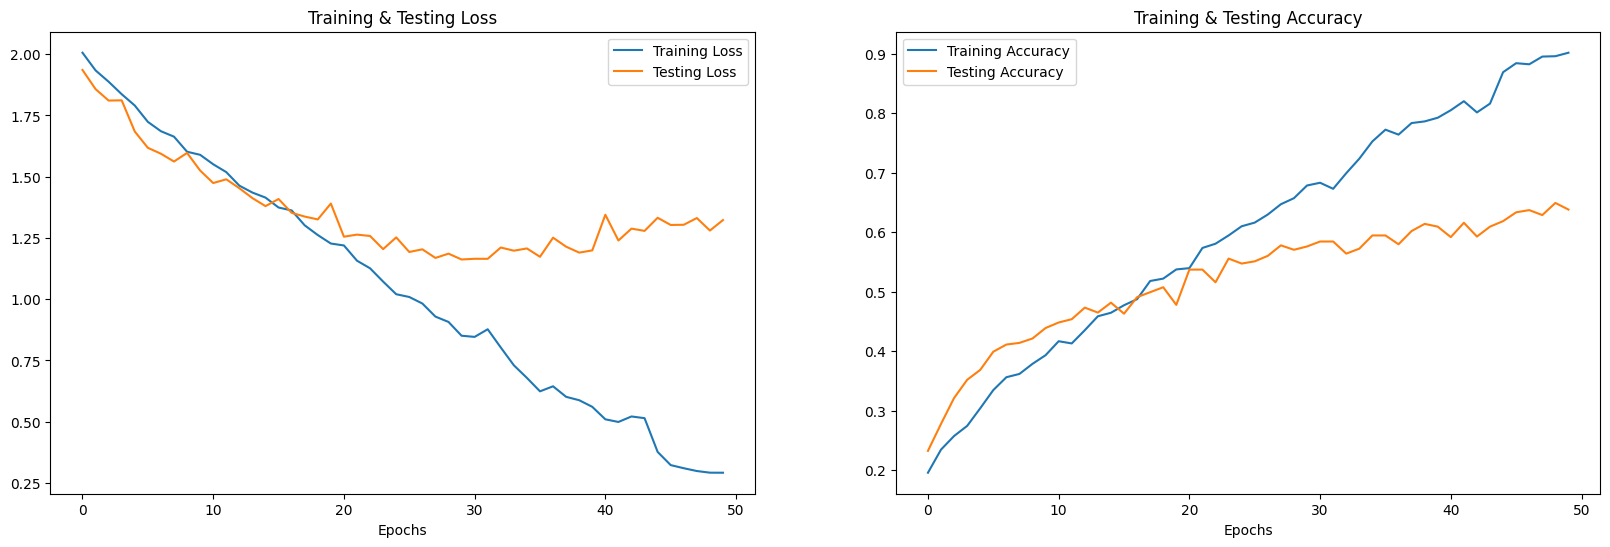

In [58]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [59]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 2s 45ms/step


In [60]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1            angry         happy
2         surprise      surprise
3              sad       neutral
4         surprise      surprise
5         surprise      surprise
6          neutral          calm
7            happy       disgust
8             calm          calm
9         surprise      surprise

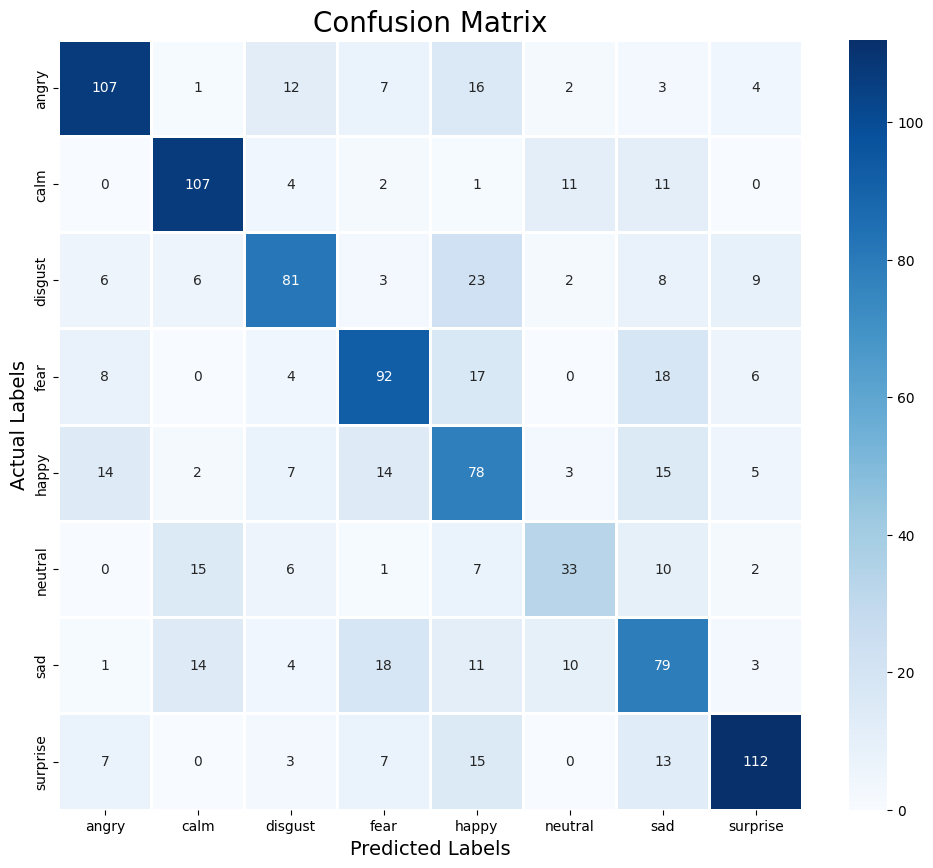

In [61]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.70      0.73       152
        calm       0.74      0.79      0.76       136
     disgust       0.67      0.59      0.63       138
        fear       0.64      0.63      0.64       145
       happy       0.46      0.57      0.51       138
     neutral       0.54      0.45      0.49        74
         sad       0.50      0.56      0.53       140
    surprise       0.79      0.71      0.75       157

    accuracy                           0.64      1080
   macro avg       0.64      0.63      0.63      1080
weighted avg       0.65      0.64      0.64      1080



In [68]:
total_instances = np.sum(cm.to_numpy())
correct_predictions = np.trace(cm)

accuracy = correct_predictions / total_instances
print(f'Overall Accuracy: {accuracy:.2%}')

Overall Accuracy: 63.80%


We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed, noise.



We overall achieved 63.8% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.